In [53]:
import numpy as np
from enum import Enum
from math import exp

Methods = Enum('Methods', ['Classic', 'Momentum', 'AdaGrad', 'RMSprop', 'Adam', 'Nesterov'])
Regularization = Enum('Regularization', ['WithoutRegularization', 'L1', 'L2', 'Elastic'])
LearningRate = Enum('LearningRate', ['Const', 'ConstWithLRS', 'Dichotomy'])


def sign(x):
    if x > 0:
        return 1
    elif x == 0:
        return 0
    else:
        return -1


class LinearRegression:
    def __init__(self, T, W, X, Y, regularization=Regularization.WithoutRegularization, l1=0.1, l2=0.1):
        self.T = np.array([T[i % len(T)](X[i // len(T)]) for i in range(len(T) * len(X))]).reshape(len(X), len(T))
        self.W = W
        self.X = X
        self.Y = Y
        self.regularization = regularization
        self.l1 = l1
        self.l2 = l2

    def sse(self, W_Arg):
        val = sum([(np.dot(self.T[i], W_Arg) - self.Y[i]) ** 2 for i in range(len(self.X))])
        match self.regularization:
            case Regularization.L1:
                val += self.l1 * sum([abs(w) for w in self.W]) / len(self.W)
            case Regularization.L2:
                val += self.l2 * sum([w ** 2 for w in self.W]) / len(self.W)
            case Regularization.Elastic:
                val += (self.l1 * sum([abs(w) for w in self.W])) / len(self.W) + (
                            self.l2 * sum([w ** 2 for w in self.W])) / len(self.W)
        return val

    def grad_by_components(self, index_components, W_Arg):
        grad_with_batch = np.zeros(len(W_Arg))
        for i in index_components:
            grad_with_batch += 2 * (np.dot(self.T[i], W_Arg) - self.Y[i]) * self.T[i]
        match self.regularization:
            case Regularization.L1:
                grad_with_batch += self.l1 * np.array([sign(w) for w in self.W]) / len(self.W)
            case Regularization.L2:
                grad_with_batch += self.l2 * 2 * self.W / len(self.W)
            case Regularization.Elastic:
                grad_with_batch += (self.l1 * np.array([sign(w) for w in self.W])) / len(self.W) + (
                            self.l2 * 2 * self.W) / len(self.W)

        return grad_with_batch


def sgd(lin_reg, lr, eps, batch, max_num_of_step, beta_1, beta_2, eps_adam, is_corr_beta_1=True, is_corr_beta_2=True, is_nesterov=False,
        lrs=lambda lr, t: lr):
    i = 0
    prev_W = lin_reg.sse(lin_reg.W)
    V = np.zeros(len(lin_reg.W))
    S = np.zeros(len(lin_reg.W))

    while True:
        components = [(i * batch + j) % len(lin_reg.X) for j in range(batch)]
        cur_w = lin_reg.W
        grad_with_batch = lin_reg.grad_by_components(components, cur_w)
        alpha = lrs(lr(lambda a: lin_reg.sse(lin_reg.W - a * grad_with_batch)), (i * batch) % len(lin_reg.X))
        if is_nesterov:
            cur_w -= alpha * beta_1 * V
            grad_with_batch = lin_reg.grad_by_components(components, cur_w)

        V = (beta_1 * V) + (1 - beta_1) * grad_with_batch
        S = (beta_2 * S) + (1 - beta_2) * (grad_with_batch ** 2)
        if is_corr_beta_1:
            V /= 1 - (beta_1 ** (i + 1))
        if is_corr_beta_2:
            S /= 1 - (beta_2 ** (i + 1))

        lin_reg.W -= alpha * (V / ((S + eps_adam) ** 0.5))
        if abs(lin_reg.sse(lin_reg.W) - prev_W) < eps or i >= max_num_of_step:
            break
        prev_W = lin_reg.sse(lin_reg.W)
        i += 1

    return i


def sgd_handler(lin_reg, lr, method, batch=1, beta_1=0.9, beta_2=0.999, eps_adam=10 ** -8, eps=0.001,
                max_num_of_step=10000, lrs=lambda lr, t: lr):
    match method:
        case Methods.Classic:
            return sgd(lin_reg, lr, eps, batch, max_num_of_step, 0, 1, 1, False, False, lrs=lrs)
        case Methods.Momentum:
            return sgd(lin_reg, lr, eps, batch, max_num_of_step, beta_1, 1, 1, False, False, lrs=lrs)
        case Methods.AdaGrad:
            return sgd(lin_reg, lr, eps, batch, max_num_of_step, 0, 0, eps_adam, False, False, lrs=lrs)
        case Methods.RMSprop:
            return sgd(lin_reg, lr, eps, batch, max_num_of_step, 0, beta_2, eps_adam, False, lrs=lrs)
        case Methods.Adam:
            return sgd(lin_reg, lr, eps, batch, max_num_of_step, beta_1, beta_2, eps_adam, lrs=lrs)
        case Methods.Nesterov:
            return sgd(lin_reg, lr, eps, batch, max_num_of_step, beta_1, 1, 1, False, False, True, lrs=lrs)


def lr_dichotomy(eps, delt):
    return lambda lin_reg: dichotomy(lin_reg, 0, right_border_calc(lin_reg), eps, delt)


def right_border_calc(func):
    right_start = 0.0000001
    zero = func(0.)
    while zero >= func(right_start):
        right_start *= 1.3

    return right_start


def dichotomy(func, a_1, a_2, eps, delt):
    while abs(a_1 - a_2) >= eps:
        new_a_1 = (a_1 + a_2) / 2 - delt
        new_a_2 = (a_1 + a_2) / 2 + delt
        fv1 = func(new_a_1)
        fv2 = func(new_a_2)
        if fv2 > fv1:
            a_2 = new_a_2
        elif fv2 < fv1:
            a_1 = new_a_1
        else:
            a_1 = new_a_1
            a_2 = new_a_2
    return (a_1 + a_2) / 2


def exp_lrs(decay=0.99):
    return lambda lr, t: lr * (decay ** t)

In [54]:
import matplotlib.pyplot as plt


def visualise_points(linear_reg):
    x = np.linspace(-10, 10, 1000)
    y = linear_reg.W[0] * x + linear_reg.W[1]
    plt.plot(x, y, '-r')
    plt.plot(linear_reg.X, linear_reg.Y, 'og', linestyle='None')
    plt.xlabel("x")
    plt.show()
    print(linear_reg.W)
    print(linear_reg.sse(linear_reg.W))

Methods.Classic Regularization.WithoutRegularization LearningRate.Const


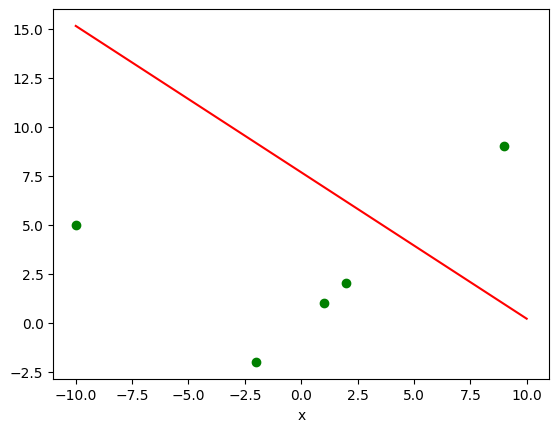

[-0.74654709  7.66981717]
344.65291429435626
Count rates: 10000



Methods.Classic Regularization.WithoutRegularization LearningRate.ConstWithLRS


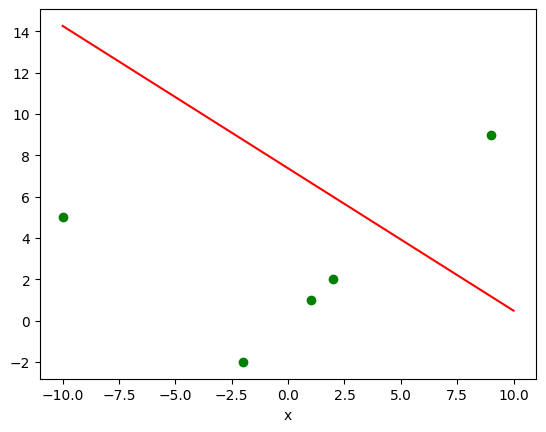

[-0.6893316   7.37467932]
311.11945313880585
Count rates: 10000



Methods.Classic Regularization.WithoutRegularization LearningRate.Dichotomy


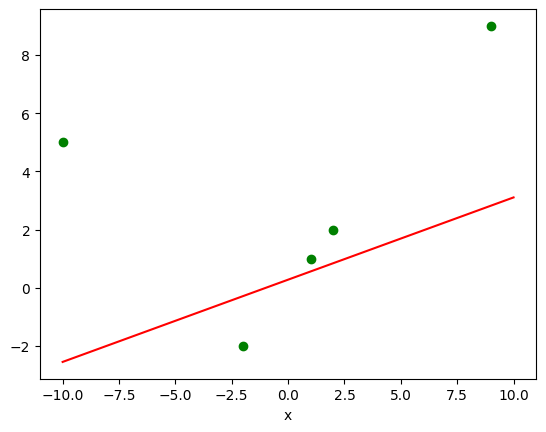

[0.28256078 0.28256067]
99.48723323888015
Count rates: 1



Methods.Classic Regularization.L1 LearningRate.Const


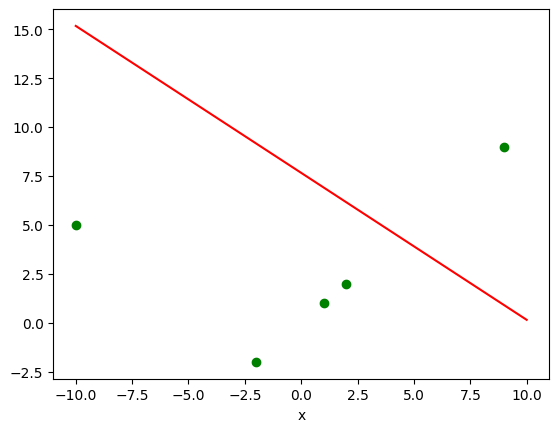

[-0.75099266  7.66097509]
346.28155029949323
Count rates: 10000



Methods.Classic Regularization.L1 LearningRate.ConstWithLRS


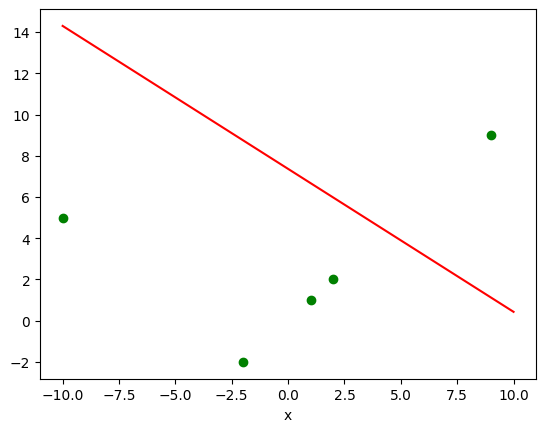

[-0.69352152  7.36483296]
312.52817284276216
Count rates: 10000



Methods.Classic Regularization.L1 LearningRate.Dichotomy


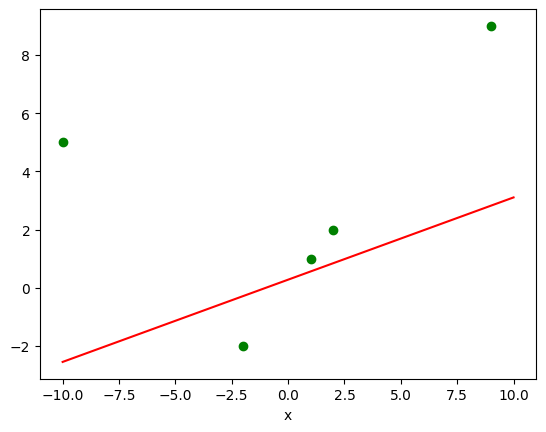

[0.28256078 0.28256067]
99.51548931070113
Count rates: 1



Methods.Classic Regularization.L2 LearningRate.Const


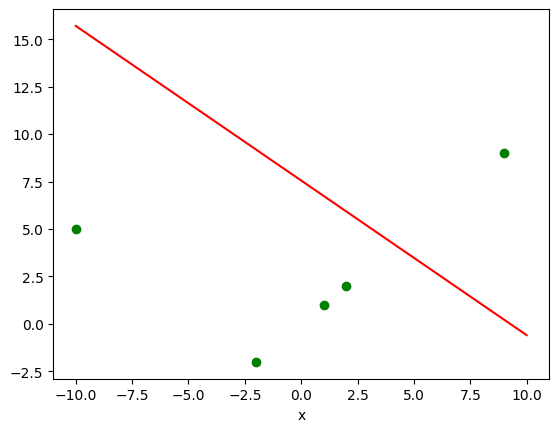

[-0.8144609   7.55315147]
367.73433282488367
Count rates: 10000



Methods.Classic Regularization.L2 LearningRate.ConstWithLRS


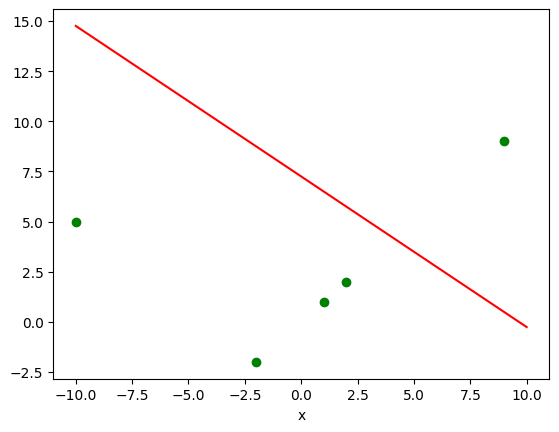

[-0.75083255  7.24746757]
330.03839189628525
Count rates: 10000



Methods.Classic Regularization.L2 LearningRate.Dichotomy


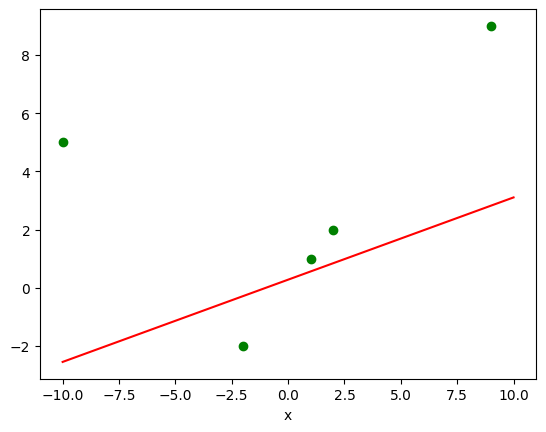

[0.28256078 0.28256067]
99.49521729488909
Count rates: 1



Methods.Classic Regularization.Elastic LearningRate.Const


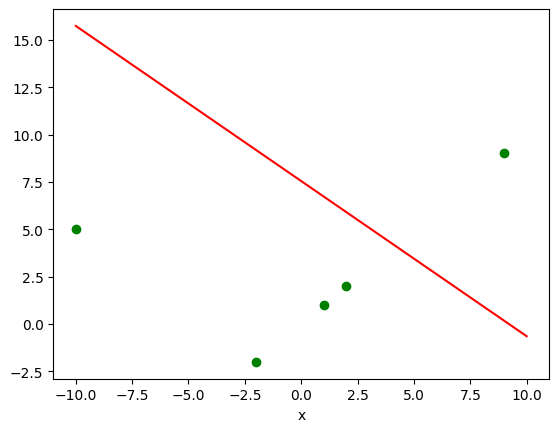

[-0.81882684  7.54442489]
369.45344458114323
Count rates: 10000



Methods.Classic Regularization.Elastic LearningRate.ConstWithLRS


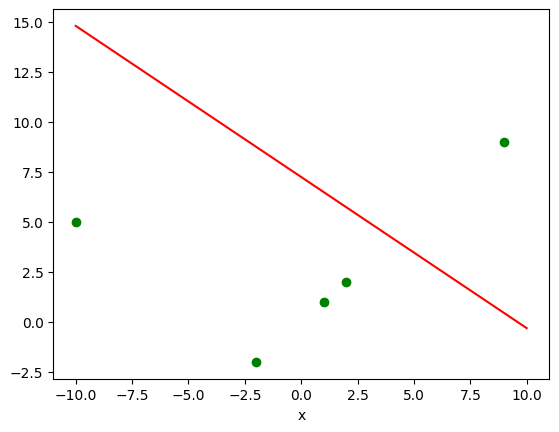

[-0.75493913  7.23777321]
331.52342662452116
Count rates: 10000



Methods.Classic Regularization.Elastic LearningRate.Dichotomy


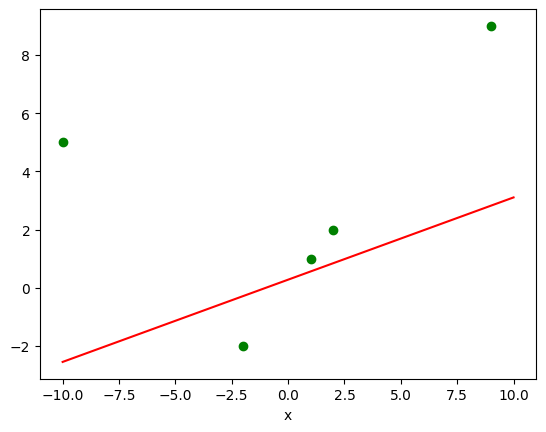

[0.28256078 0.28256066]
99.52347336642751
Count rates: 1



Methods.Momentum Regularization.WithoutRegularization LearningRate.Const


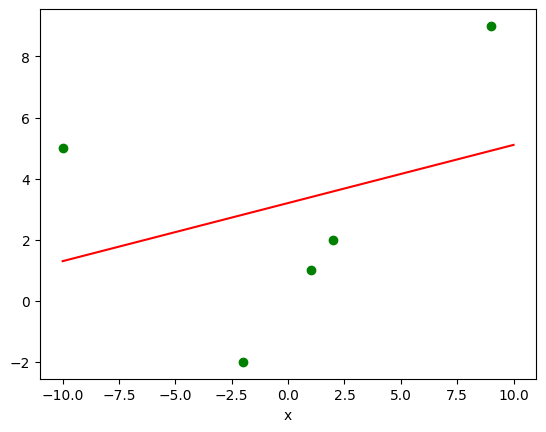

[0.19031467 3.20193538]
61.860453850394336
Count rates: 10000



Methods.Momentum Regularization.WithoutRegularization LearningRate.ConstWithLRS


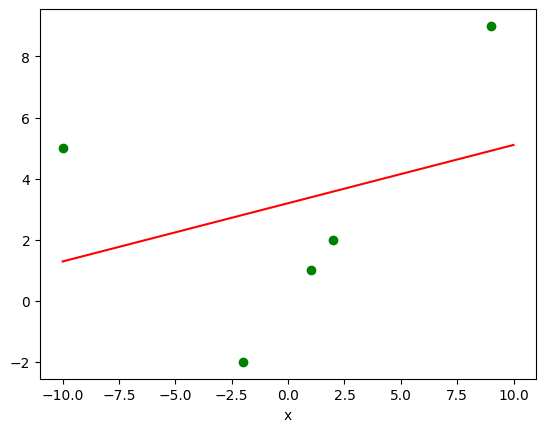

[0.19074802 3.19615954]
61.84566457611415
Count rates: 10000



Methods.Momentum Regularization.WithoutRegularization LearningRate.Dichotomy


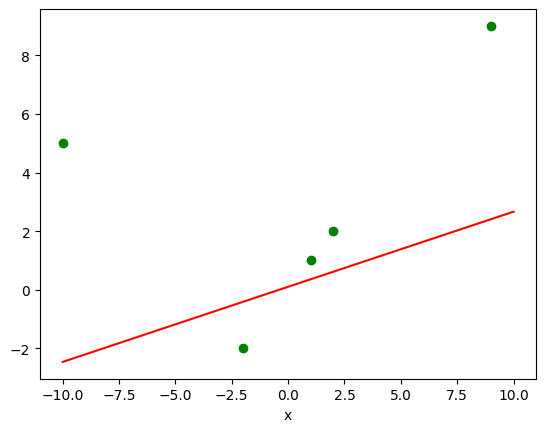

[0.25618592 0.10210597]
103.96400819929238
Count rates: 6



Methods.Momentum Regularization.L1 LearningRate.Const


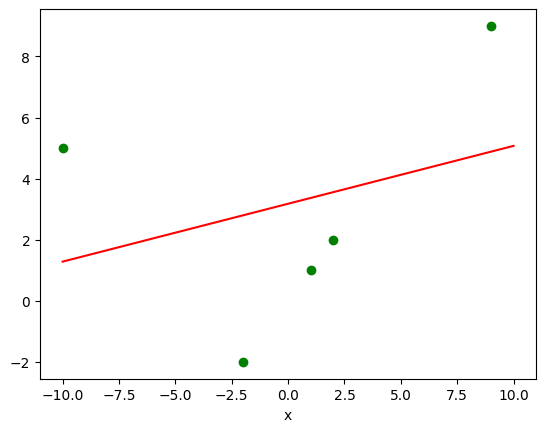

[0.18946588 3.17820835]
61.99039513366119
Count rates: 10000



Methods.Momentum Regularization.L1 LearningRate.ConstWithLRS


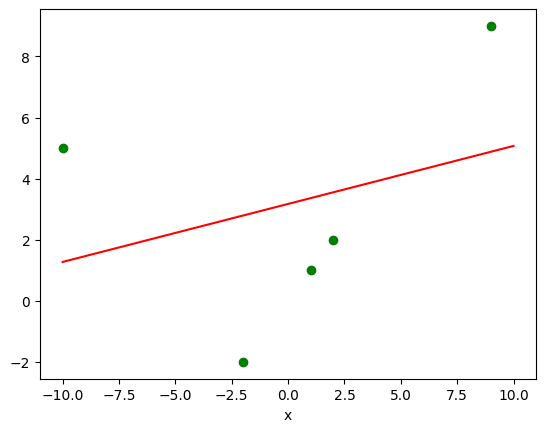

[0.18990357 3.17240161]
61.97648078328543
Count rates: 10000



Methods.Momentum Regularization.L1 LearningRate.Dichotomy


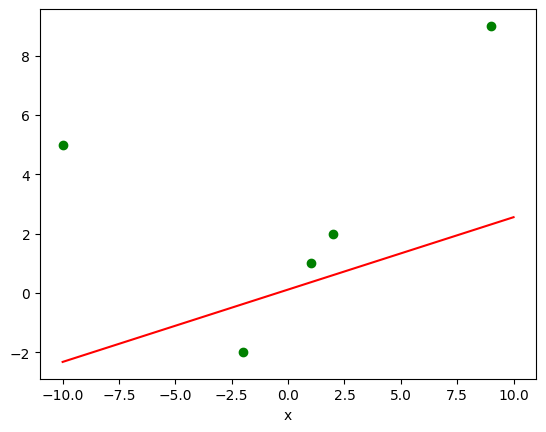

[0.24382477 0.11693402]
103.36800203442907
Count rates: 7



Methods.Momentum Regularization.L2 LearningRate.Const


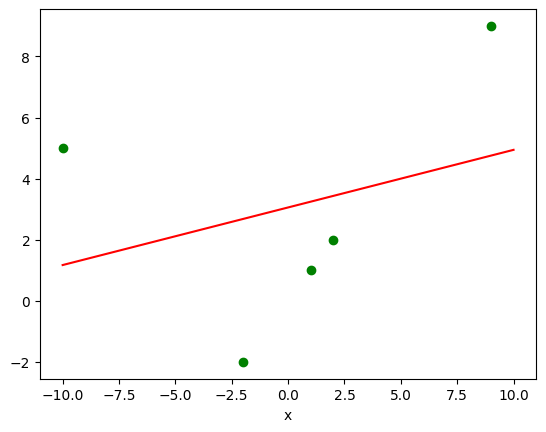

[0.18859172 3.05720647]
62.15582821860298
Count rates: 10000



Methods.Momentum Regularization.L2 LearningRate.ConstWithLRS


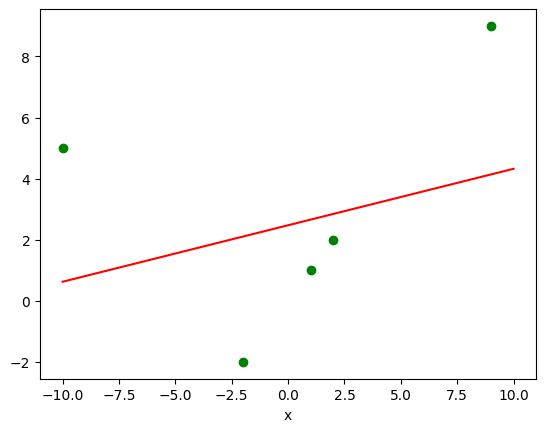

[0.18491531 2.47419055]
63.393741382185354
Count rates: 70



Methods.Momentum Regularization.L2 LearningRate.Dichotomy


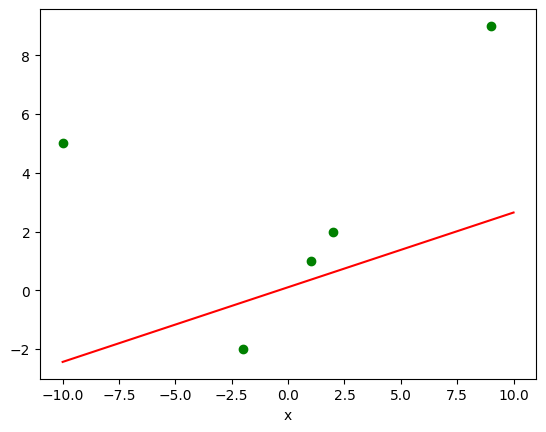

[0.25427886 0.10590014]
103.82552526658259
Count rates: 6



Methods.Momentum Regularization.Elastic LearningRate.Const


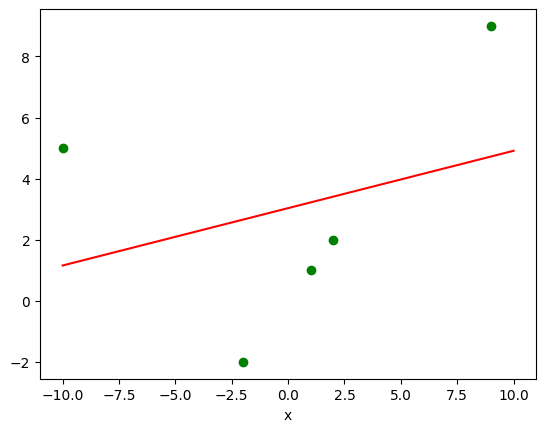

[0.18775465 3.03455221]
62.3067442022085
Count rates: 10000



Methods.Momentum Regularization.Elastic LearningRate.ConstWithLRS


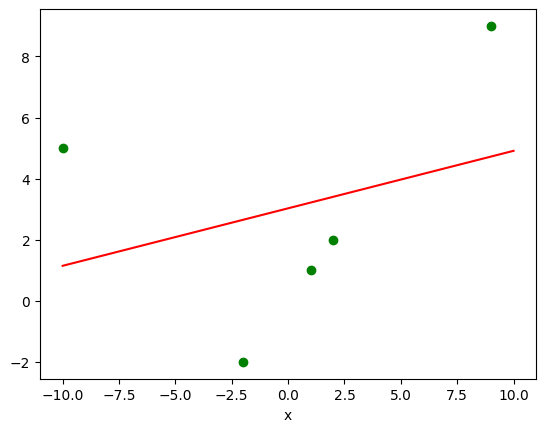

[0.18822997 3.02881528]
62.2988629812162
Count rates: 10000



Methods.Momentum Regularization.Elastic LearningRate.Dichotomy


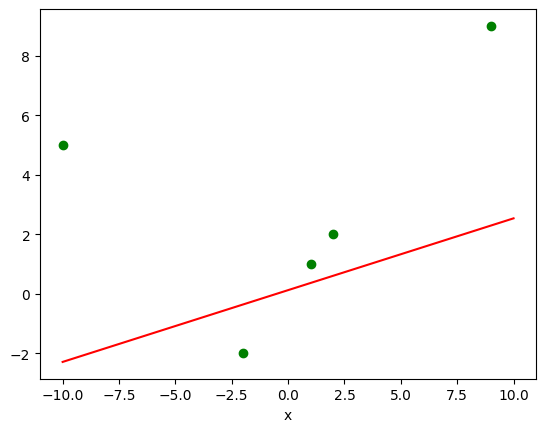

[0.24118455 0.12349651]
103.15080036715965
Count rates: 7



Methods.AdaGrad Regularization.WithoutRegularization LearningRate.Const


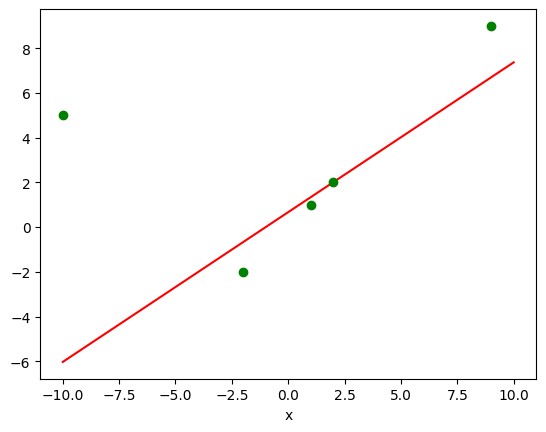

[0.6700228  0.67009049]
128.83737210397575
Count rates: 10000



Methods.AdaGrad Regularization.WithoutRegularization LearningRate.ConstWithLRS


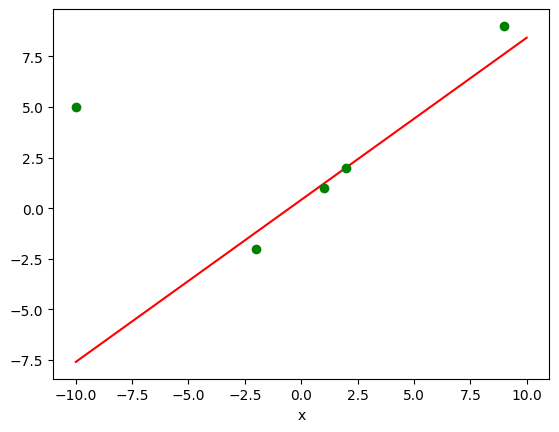

[0.80046349 0.41174355]
161.19922038843237
Count rates: 10000



Methods.AdaGrad Regularization.WithoutRegularization LearningRate.Dichotomy


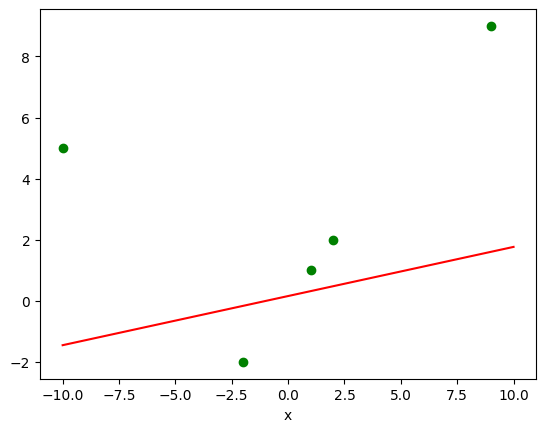

[0.16090079 0.15676737]
102.46671811199005
Count rates: 4



Methods.AdaGrad Regularization.L1 LearningRate.Const


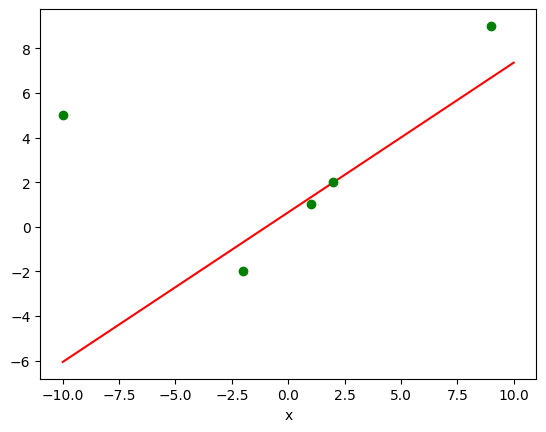

[0.67036775 0.64999483]
129.43387526863287
Count rates: 10000



Methods.AdaGrad Regularization.L1 LearningRate.ConstWithLRS


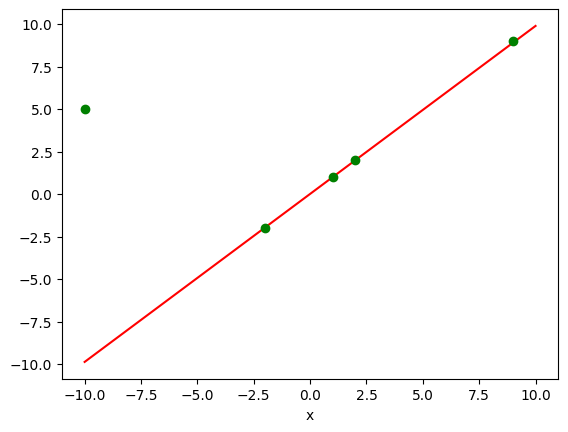

[0.9885513  0.00855201]
221.383954420712
Count rates: 10000



Methods.AdaGrad Regularization.L1 LearningRate.Dichotomy


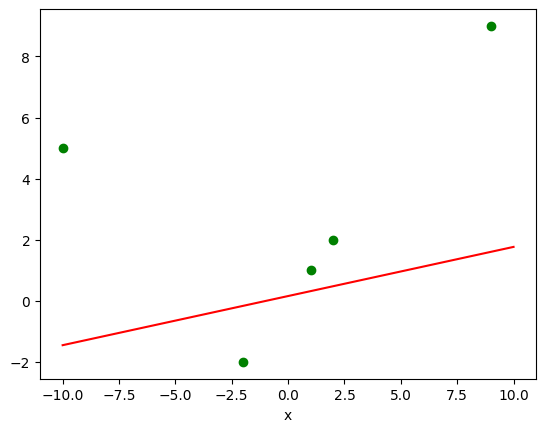

[0.16090079 0.15676737]
102.48260151965243
Count rates: 4



Methods.AdaGrad Regularization.L2 LearningRate.Const


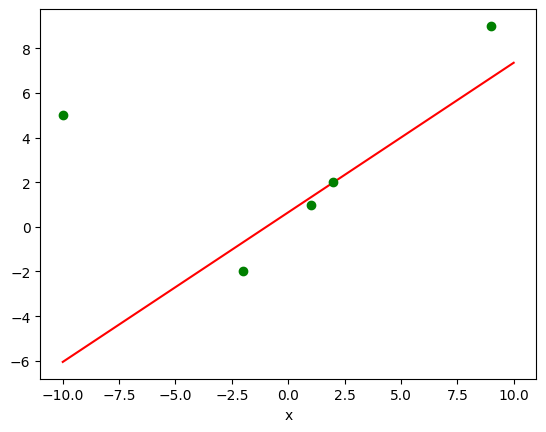

[0.67006217 0.64983374]
129.36182644417931
Count rates: 10000



Methods.AdaGrad Regularization.L2 LearningRate.ConstWithLRS


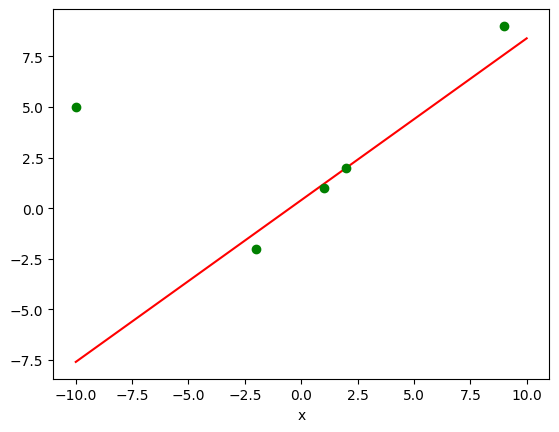

[0.79896353 0.39689477]
161.28861182893309
Count rates: 10000



Methods.AdaGrad Regularization.L2 LearningRate.Dichotomy


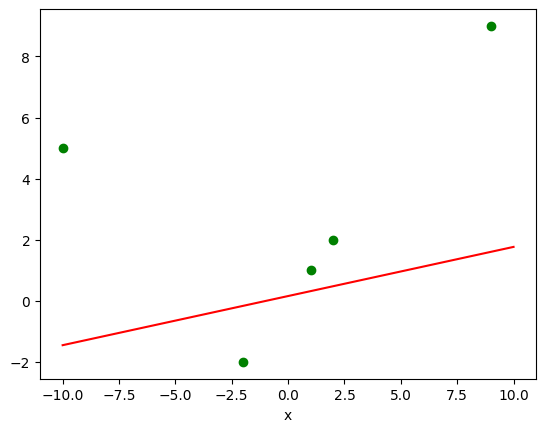

[0.16090079 0.15676737]
102.46924136550861
Count rates: 4



Methods.AdaGrad Regularization.Elastic LearningRate.Const


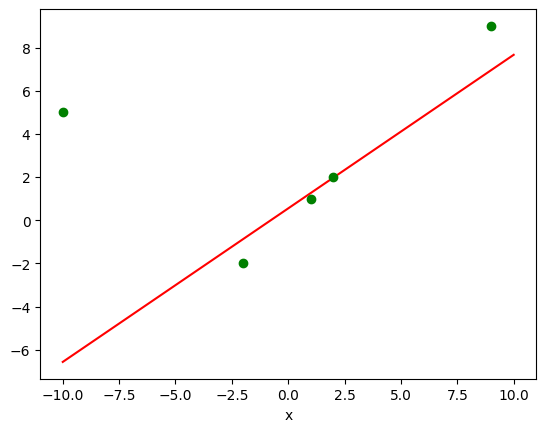

[0.71123629 0.54971752]
139.33680937234354
Count rates: 10000



Methods.AdaGrad Regularization.Elastic LearningRate.ConstWithLRS


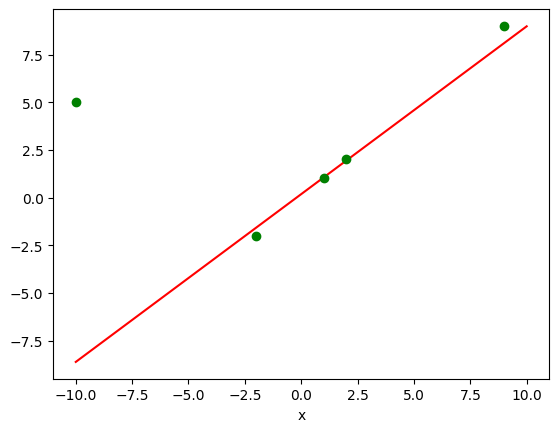

[0.87997577 0.17978688]
186.59116922913051
Count rates: 10000



Methods.AdaGrad Regularization.Elastic LearningRate.Dichotomy


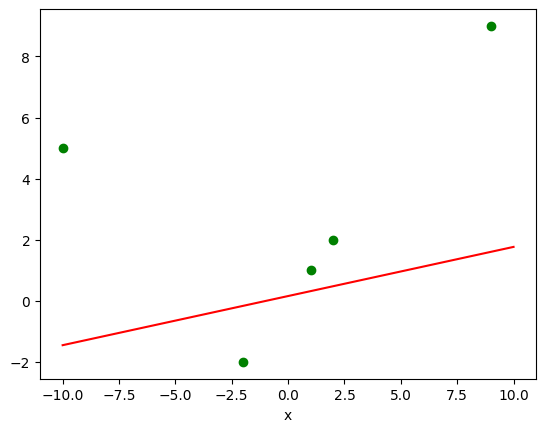

[0.16090079 0.15676737]
102.4851247731711
Count rates: 4



Methods.RMSprop Regularization.WithoutRegularization LearningRate.Const


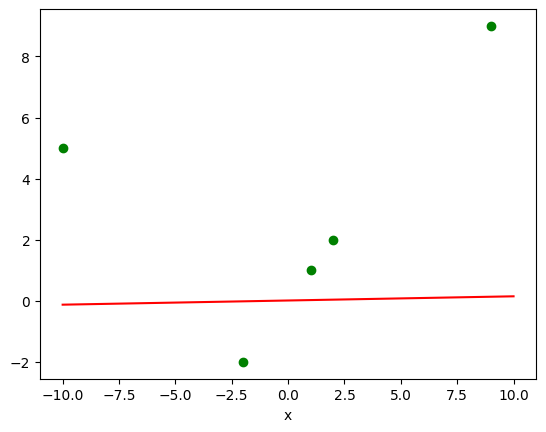

[0.01368667 0.01109367]
113.6084632017984
Count rates: 3



Methods.RMSprop Regularization.WithoutRegularization LearningRate.ConstWithLRS


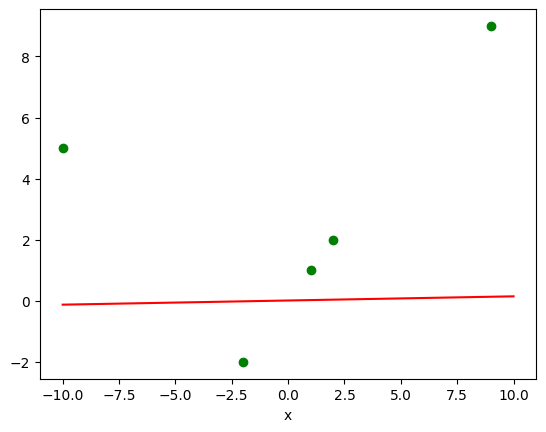

[0.0136306  0.01108065]
113.61304736423057
Count rates: 3



Methods.RMSprop Regularization.WithoutRegularization LearningRate.Dichotomy


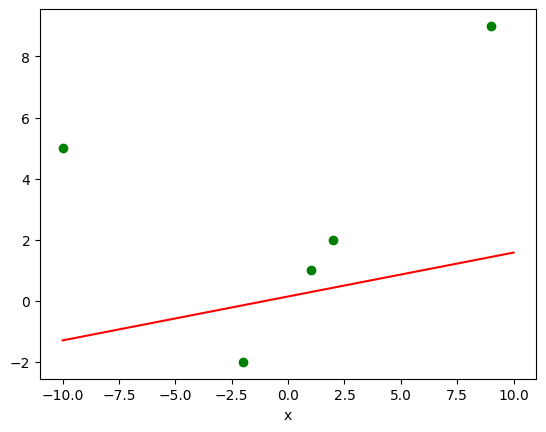

[0.14373771 0.14248784]
103.25336253258237
Count rates: 3



Methods.RMSprop Regularization.L1 LearningRate.Const


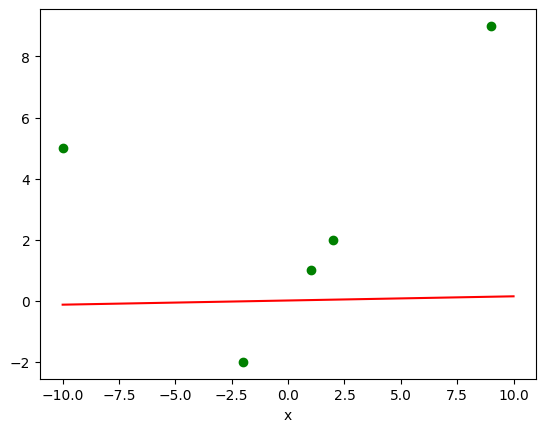

[0.01367532 0.01108191]
113.61090180372098
Count rates: 3



Methods.RMSprop Regularization.L1 LearningRate.ConstWithLRS


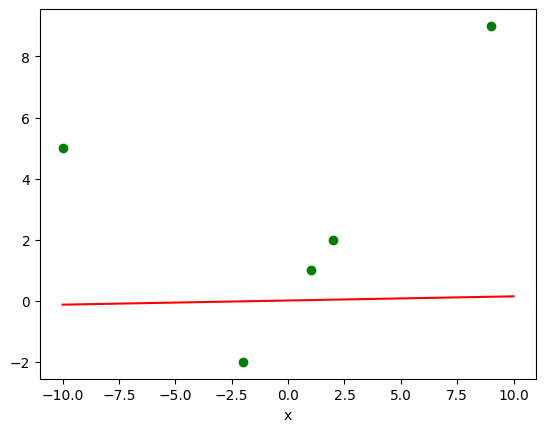

[0.01361936 0.01106902]
113.61547023167446
Count rates: 3



Methods.RMSprop Regularization.L1 LearningRate.Dichotomy


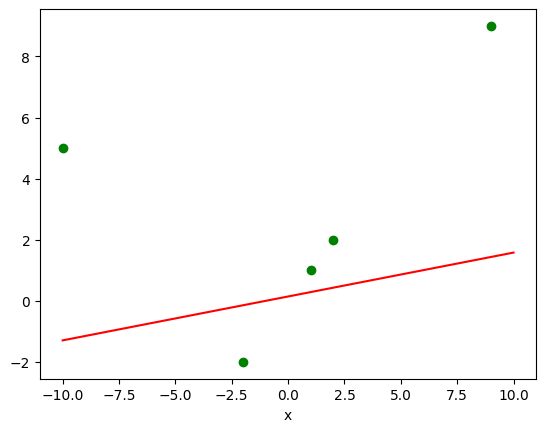

[0.14371887 0.14246879]
103.26869452650342
Count rates: 3



Methods.RMSprop Regularization.L2 LearningRate.Const


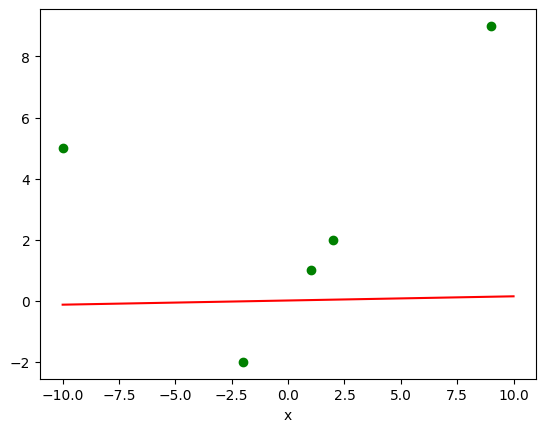

[0.01368644 0.01109343]
113.60850294321831
Count rates: 3



Methods.RMSprop Regularization.L2 LearningRate.ConstWithLRS


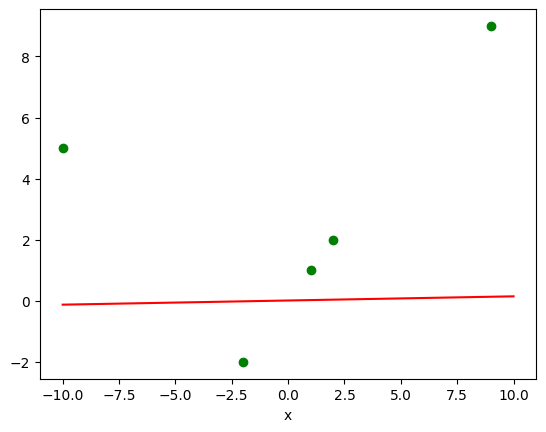

[0.01363037 0.01108041]
113.61308676227277
Count rates: 3



Methods.RMSprop Regularization.L2 LearningRate.Dichotomy


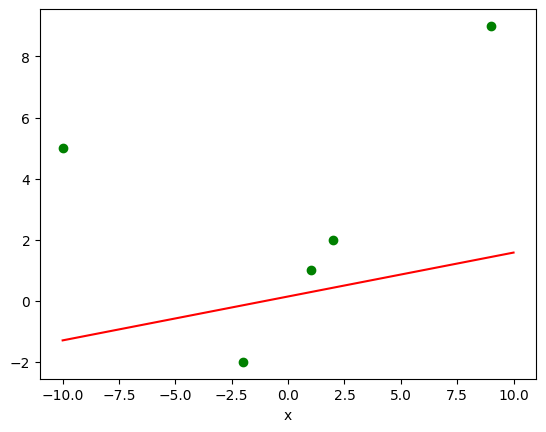

[0.14373239 0.14248246]
103.25569946962965
Count rates: 3



Methods.RMSprop Regularization.Elastic LearningRate.Const


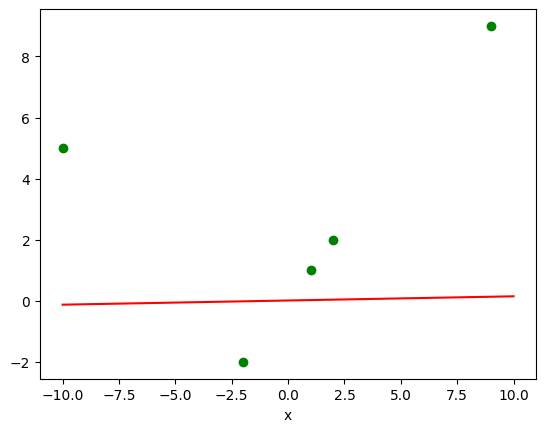

[0.01367509 0.01108168]
113.61094150053961
Count rates: 3



Methods.RMSprop Regularization.Elastic LearningRate.ConstWithLRS


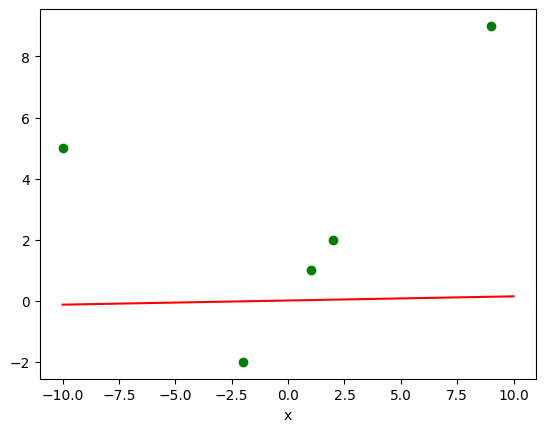

[0.01361913 0.01106878]
113.61550958566797
Count rates: 3



Methods.RMSprop Regularization.Elastic LearningRate.Dichotomy


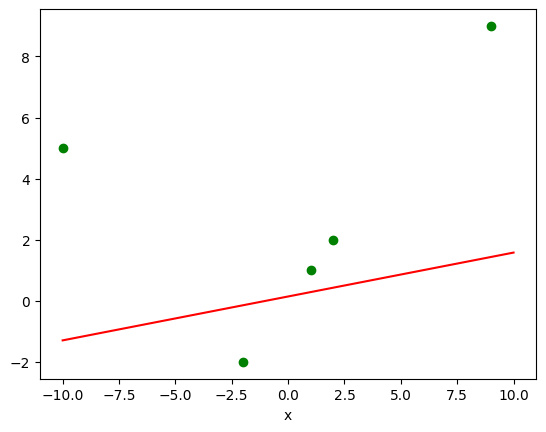

[0.14371355 0.1424634 ]
103.27103047473926
Count rates: 3



Methods.Adam Regularization.WithoutRegularization LearningRate.Const


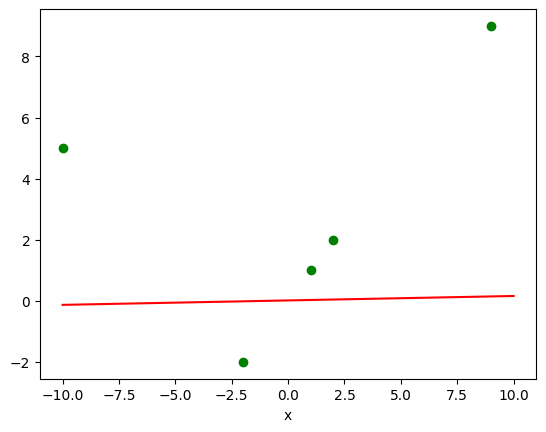

[0.01452724 0.01323274]
113.48181162983838
Count rates: 5



Methods.Adam Regularization.WithoutRegularization LearningRate.ConstWithLRS


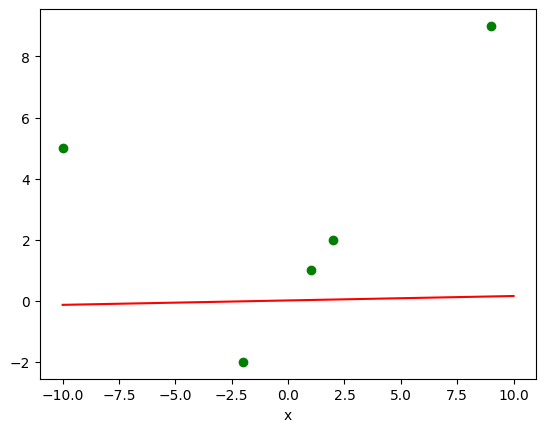

[0.01446453 0.01319281]
113.48767549220537
Count rates: 5



Methods.Adam Regularization.WithoutRegularization LearningRate.Dichotomy


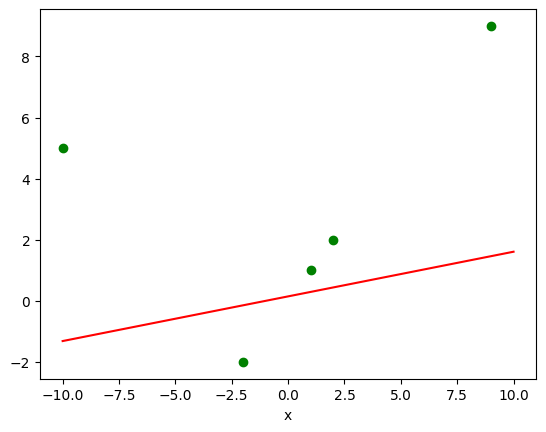

[0.14625027 0.1455756 ]
103.1026083522538
Count rates: 4



Methods.Adam Regularization.L1 LearningRate.Const


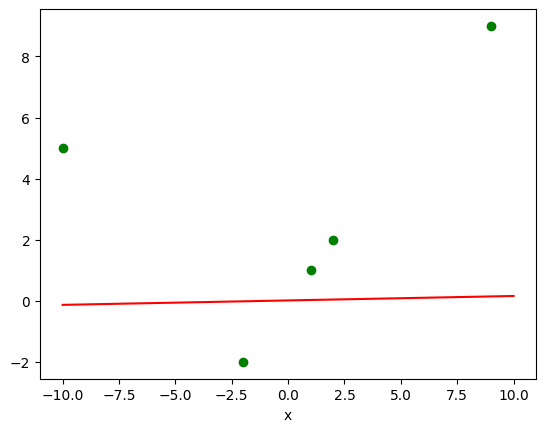

[0.01452031 0.01322546]
113.48393283954344
Count rates: 5



Methods.Adam Regularization.L1 LearningRate.ConstWithLRS


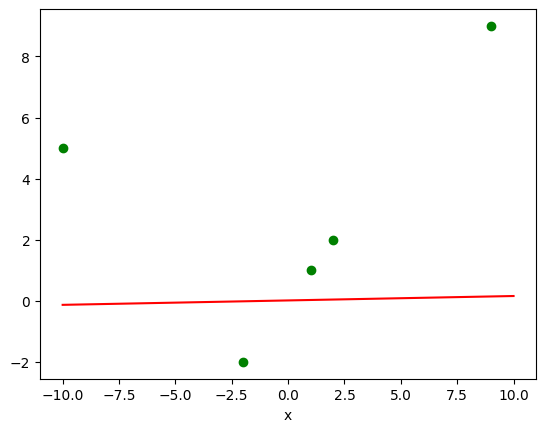

[0.01445768 0.01318563]
113.48978266682597
Count rates: 5



Methods.Adam Regularization.L1 LearningRate.Dichotomy


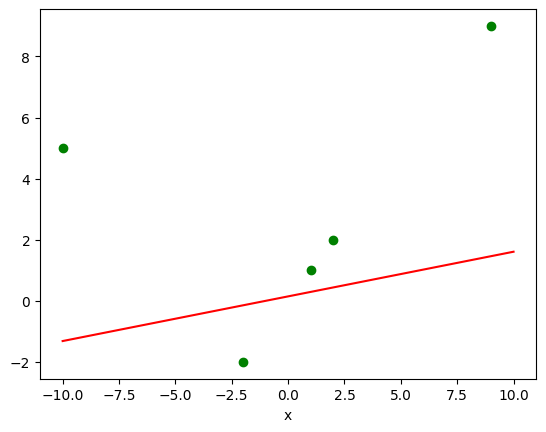

[0.14624053 0.14556561]
103.11772192676064
Count rates: 4



Methods.Adam Regularization.L2 LearningRate.Const


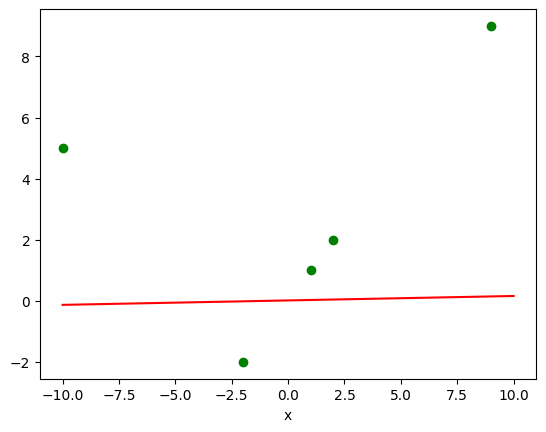

[0.0145271  0.01323259]
113.48184578149288
Count rates: 5



Methods.Adam Regularization.L2 LearningRate.ConstWithLRS


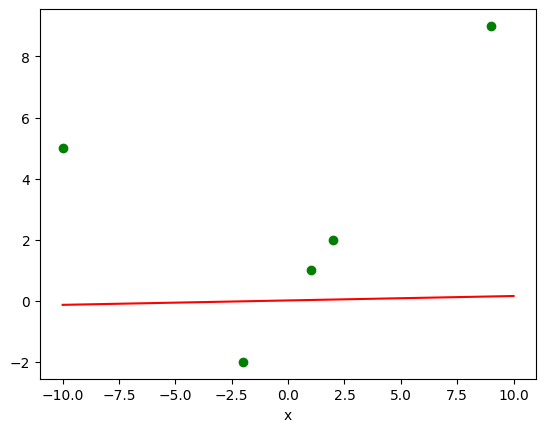

[0.01446439 0.01319267]
113.48770931658275
Count rates: 5



Methods.Adam Regularization.L2 LearningRate.Dichotomy


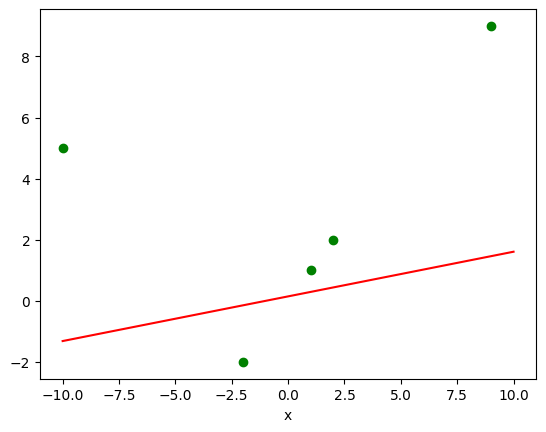

[0.14624752 0.14557278]
103.10488518305465
Count rates: 4



Methods.Adam Regularization.Elastic LearningRate.Const


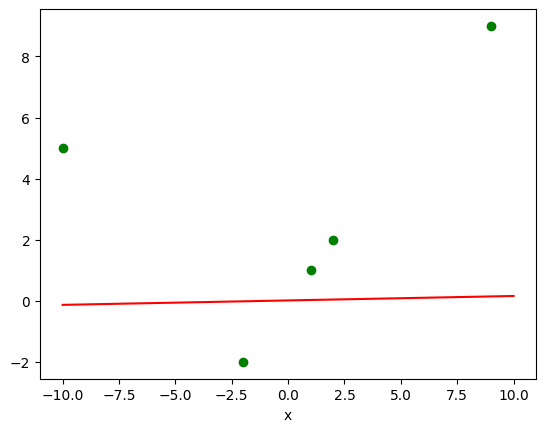

[0.01452017 0.01322531]
113.48396696489768
Count rates: 5



Methods.Adam Regularization.Elastic LearningRate.ConstWithLRS


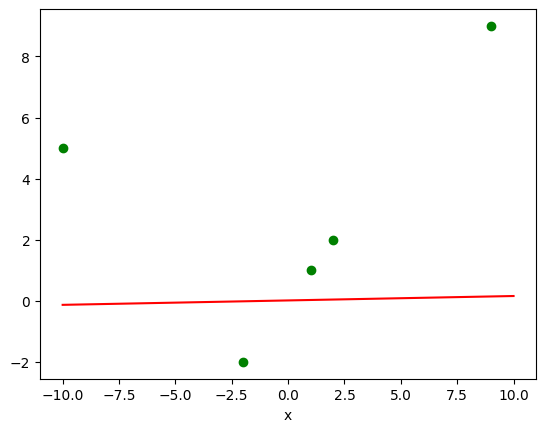

[0.01445754 0.01318548]
113.48981646530129
Count rates: 5



Methods.Adam Regularization.Elastic LearningRate.Dichotomy


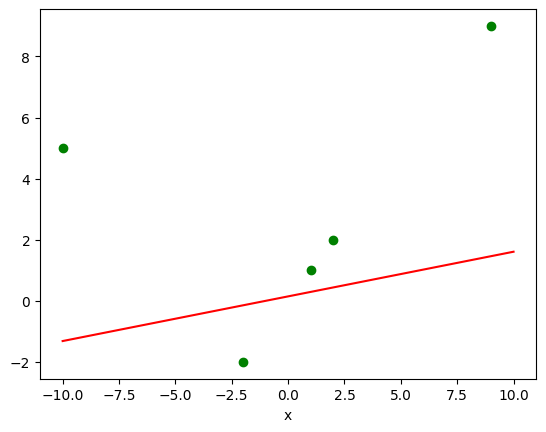

[0.14623778 0.14556278]
103.11999826036067
Count rates: 4



Methods.Nesterov Regularization.WithoutRegularization LearningRate.Const


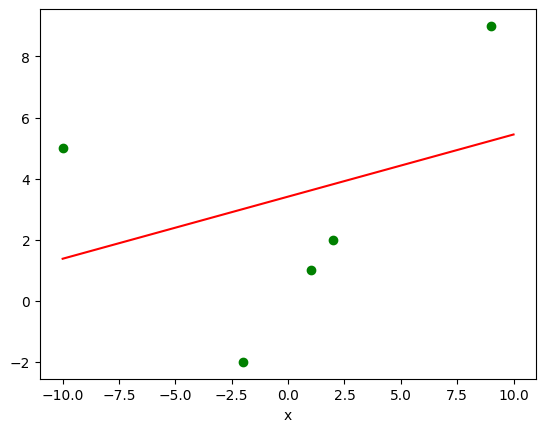

[0.20338731 3.41180606]
62.4365519423329
Count rates: 10000



Methods.Nesterov Regularization.WithoutRegularization LearningRate.ConstWithLRS


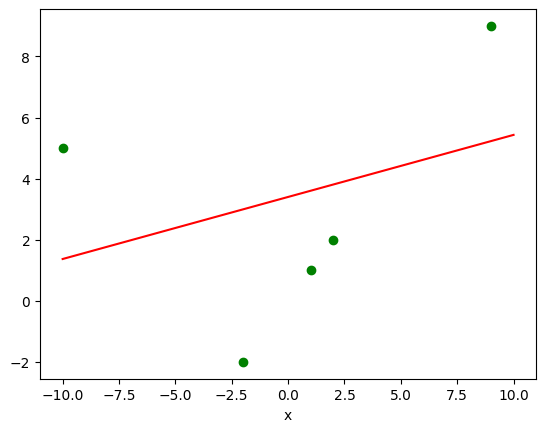

[0.20316982 3.40090514]
62.39285443210771
Count rates: 10000



Methods.Nesterov Regularization.WithoutRegularization LearningRate.Dichotomy


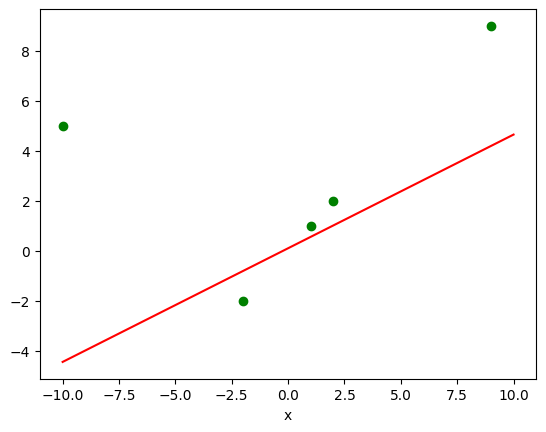

[0.45489966 0.10269866]
114.89720536032117
Count rates: 5



Methods.Nesterov Regularization.L1 LearningRate.Const


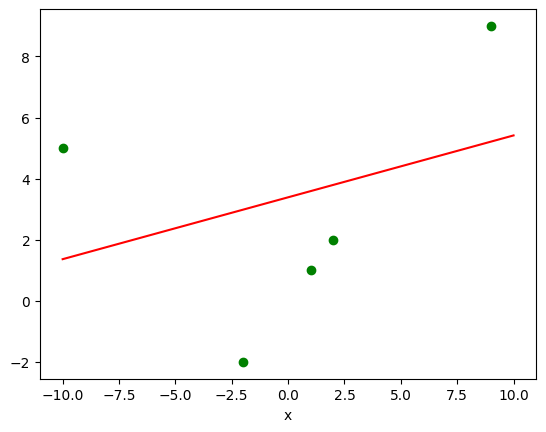

[0.20256882 3.38938201]
62.528667768354296
Count rates: 10000



Methods.Nesterov Regularization.L1 LearningRate.ConstWithLRS


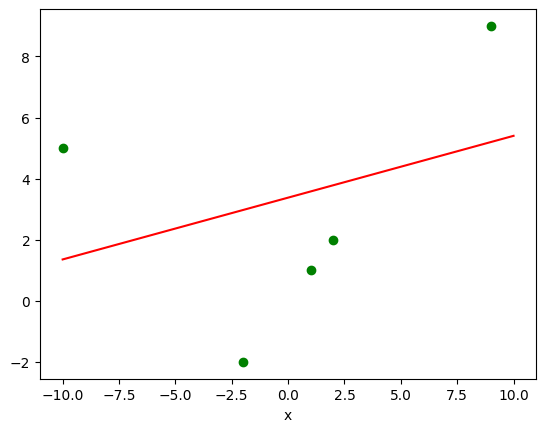

[0.20235223 3.37841406]
62.48666664496867
Count rates: 10000



Methods.Nesterov Regularization.L1 LearningRate.Dichotomy


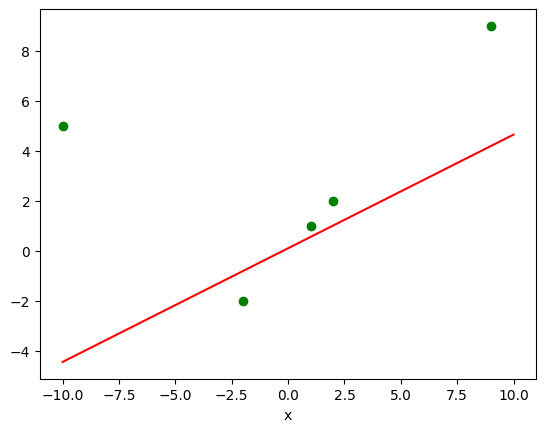

[0.45480985 0.10258124]
114.9201386227276
Count rates: 5



Methods.Nesterov Regularization.L2 LearningRate.Const


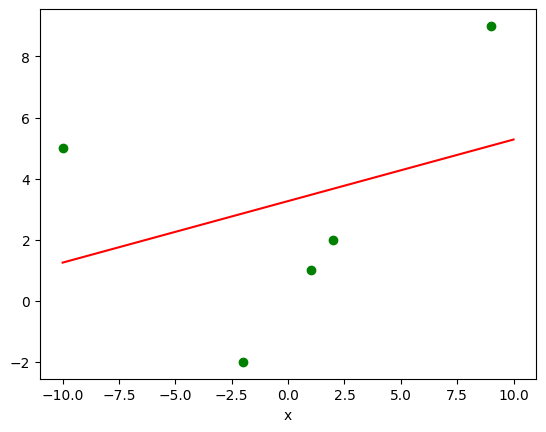

[0.20149961 3.26609246]
62.48385290353366
Count rates: 10000



Methods.Nesterov Regularization.L2 LearningRate.ConstWithLRS


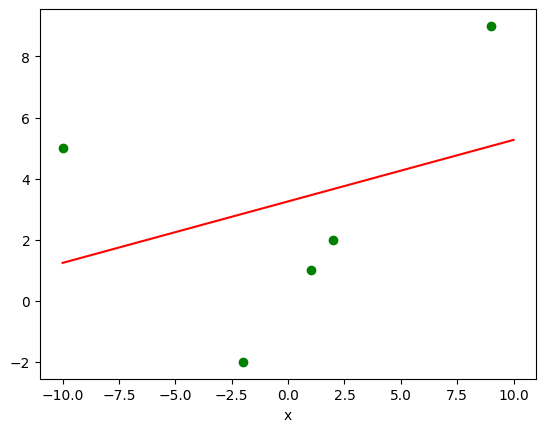

[0.20130405 3.25522964]
62.452669919997994
Count rates: 10000



Methods.Nesterov Regularization.L2 LearningRate.Dichotomy


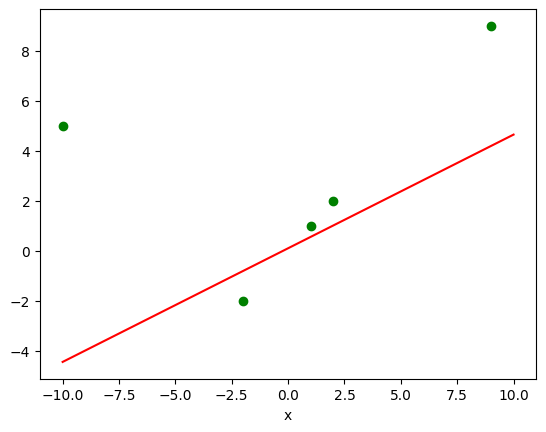

[0.45483028 0.1026567 ]
114.90285031297162
Count rates: 5



Methods.Nesterov Regularization.Elastic LearningRate.Const


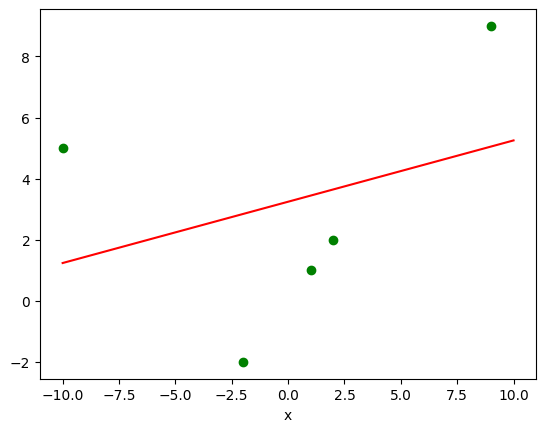

[0.20069283 3.24462768]
62.59719376340015
Count rates: 10000



Methods.Nesterov Regularization.Elastic LearningRate.ConstWithLRS


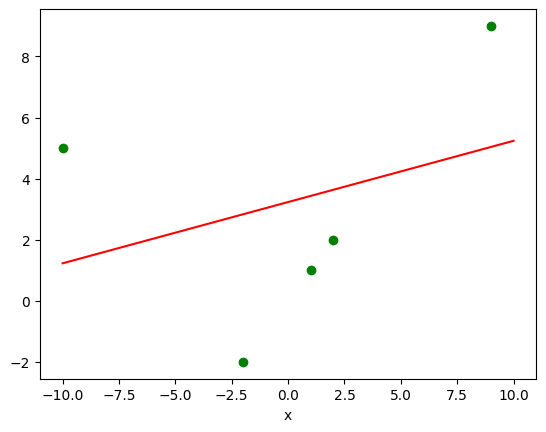

[0.20049808 3.23370347]
62.567703343532365
Count rates: 10000



Methods.Nesterov Regularization.Elastic LearningRate.Dichotomy


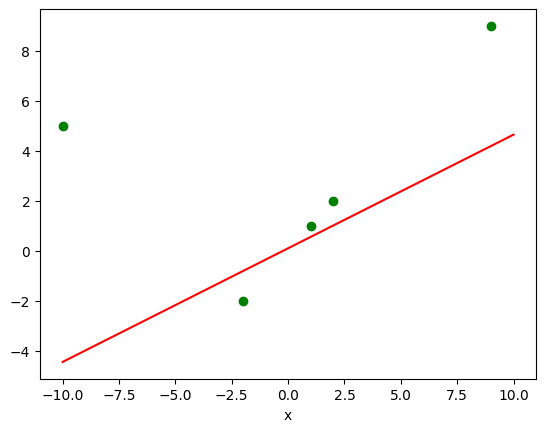

[0.45474022 0.102539  ]
114.92575944205421
Count rates: 5





In [55]:
current_t = np.array([lambda x: x, lambda x: 1.])
current_w = np.array([0., 0.])
current_x = np.array([1., 2., 9., -2., -10.])
current_y = np.array([1., 2., 9., -2., 5.])

for method in Methods:
    for regularization in Regularization:
        for lr in LearningRate:
            linear_reg_const = LinearRegression(
                current_t, current_w, current_x, current_y, regularization
            )
            print(str(method) + " " + str(regularization) + " " + str(lr))
            count_rates = 0
            if lr == LearningRate.Const:
                count_rates = sgd_handler(linear_reg_const, lambda x: 0.01, method)
            elif lr == LearningRate.ConstWithLRS:
                count_rates = sgd_handler(linear_reg_const, lambda x: 0.01, method, lrs=exp_lrs())
            elif lr == LearningRate.Dichotomy:
                count_rates = sgd_handler(linear_reg_const, lr_dichotomy(0.001, 0.0001), method)
            visualise_points(linear_reg_const)
            print('Count rates: ' + str(count_rates))
            current_w = np.array([0., 0.])
            print("\n\n")